# Evaluation for the Synthetic Pendulum Experiments
This notebook can be used to load and analyze the results generated by running `training_syntheticPendulum.py`. The notebook is meant to evaluate multiple experiments together and compute the average Performances over all experiments. (E.g. the average performance over all 9 stonewall/woodwall/wallclock scenes, as reported in the papaer)

The path to the the folder containing the experiments needs to be specified under `path_experiment`. The folder set here needs to contain the subfolders with the experiments, where those subfolders need to contain `ckpt.pth` and `./hydra/`.

In [1]:
%cd ..

/home/jan/Documents/TUDelftMSc/CVDL/project/project/PhysParamInference


In [2]:
import os
import torch
import yaml
from models.sceneRepresentation import Scene
from dataset.dataset import DynamicPixelDataset, get_split_dynamic_pixel_data, ImageDataset_CVDL
from util.initialValues import estimate_initial_values, estimate_initial_vals_pendulum
import matplotlib.pyplot as plt
from torchvision import utils
from util.util import compute_psnr, compute_iou

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [8]:
# Set the path to the experiments to analyze.
# The folder specified here needs to contain the subfolders which contain `ckpt.pth` and `./hydra/` 
path_experiment = os.path.join(
    os.path.abspath(''),
    'experiments',
    '2024-06-12',
    'pendulum_real_cvdl',
    '20-04-20_seq9',
)

save_dir = os.path.join(
    os.path.abspath(''), 
    '..', 
    'out', 
    'pendulum_real'
)

## Render Images
The following code creates images for a specific experiment. The folder containing `ckpt.pth` and `./hydra/` for this experiment needs to be specified under `path_experiment`.

In [9]:
path_folder = os.path.join(path_experiment, 'renderings')
if not os.path.isdir(path_folder):
    os.makedirs(path_folder)

# Load Config
path_conf = os.path.join(path_experiment, '.hydra','config.yaml')
with open(path_conf) as f:
    cfg = yaml.safe_load(f)

# Load Model
model = Scene(**cfg['scene']['background'])
model.add_pendulum(**cfg['ode'], **cfg['scene']['local_representation'])

path_ckpt = os.path.join(path_experiment, 'ckpt.pth')
model.load_state_dict(torch.load(path_ckpt))

model.to(device)
print("Model loaded")

Model loaded


Data loaded


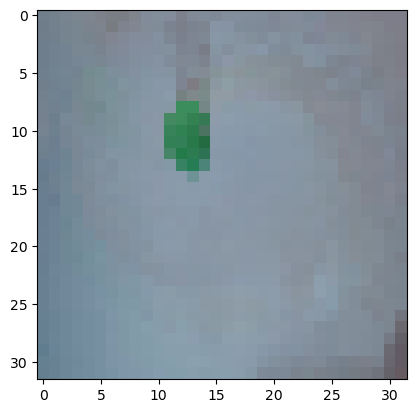

In [10]:
# Train images
# Load Data
data = ImageDataset_CVDL(
    **cfg['data'],
)

H, W = data.get_image_dim()
print("Data loaded")

# Render
tspan = data.t_steps.to(device)
model.update_trafo(tspan)
output = model.render_image(W, H)
ims = output["Image"].cpu()
masks = output['Mask'].cpu()

plt.imshow(ims[0])

# Train data
inds_to_save = [i for i in range(masks.shape[0])]

for i in inds_to_save:
    path = os.path.join(path_folder, f"{i}_train.jpg")
    utils.save_image(ims[i].permute(2, 0, 1), path)
    path = os.path.join(path_folder, f"{i}_mask_train.jpg")
    utils.save_image(masks[i], path)
    path = os.path.join(path_folder, f"{i}_gt_train.jpg")
    utils.save_image(data.get_full_images(i).permute(2, 0, 1), path)
    path = os.path.join(path_folder, f"{i}_mask_gt_train.jpg")
    utils.save_image(data.get_full_mask(i), path)

Data loaded


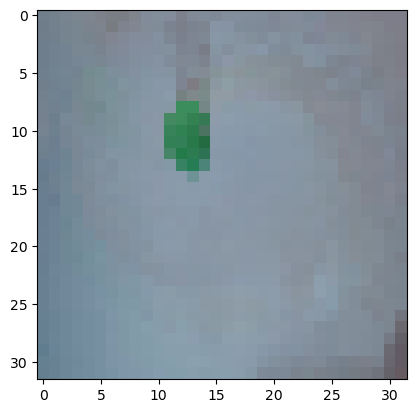

In [11]:
# Test images
# Load Data
data = ImageDataset_CVDL(
    **cfg['data'],
    test_set=True
)

H, W = data.get_image_dim()
print("Data loaded")

# Render
tspan = data.t_steps.to(device)
model.update_trafo(tspan)
output = model.render_image(W, H)
ims = output["Image"].cpu()
masks = output['Mask'].cpu()

plt.imshow(ims[0]) 

# Train data
inds_to_save = [i for i in range(masks.shape[0])]

for i in inds_to_save:
    path = os.path.join(path_folder, f"{i}_test.jpg")
    utils.save_image(ims[i].permute(2, 0, 1), path)
    path = os.path.join(path_folder, f"{i}_mask_test.jpg")
    utils.save_image(masks[i], path)
    path = os.path.join(path_folder, f"{i}_gt_test.jpg")
    utils.save_image(data.get_full_images(i).permute(2, 0, 1), path)
    path = os.path.join(path_folder, f"{i}_mask_gt_test.jpg")
    utils.save_image(data.get_full_mask(i), path)

In [12]:
import numpy as np
test_images = np.array([np.array(ims[i]) for i in range(ims.shape[0])])
test_images = test_images[-(cfg['data']['prediction_length']-cfg['data']['training_length']):]
np.savez_compressed(os.path.join(save_dir, 'test_images_ppi.npz'), test_images)